In [1]:
%cd ..
# move to the root directory of the git

C:\Users\Admin\Documents\GitHub\FLOOD_project


In [2]:
import importlib
import torch
import copy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch.nn as nn
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Enable interactive widgets in Jupyter Notebook
%matplotlib widget

from torch.utils.data import DataLoader

from models.ConvLSTM_model.ConvLSTM_pytorch.convlstm import ConvLSTM
from models.ConvLSTM_model.train_eval import evaluation_conv_lstm
from pre_processing.encode_decode_csv import decode_from_csv
from pre_processing.normalization import * 
from post_processing.cool_animation import plot_animation

In [3]:
# model save path
save_path = 'models/ConvLSTM_model/conv_lstm_4batch_8hidden.pth'

Check if GPU is available.

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


The following lines create variables to more easily specify what we use the model for (i.e., train and validate, test with dataset 1 and so on) in the following functions.

In [5]:
train_val = 'train_val'
test1 = 'test1'
test2 = 'test2'
test3 = 'test3'

Load data from decoder.

**Please note**: 
\
inputs and targets in <code>train_val</code> are stored not in the original manner. 

index 0 = 1, index 1 = 10, index 11 = 2, index 12 = 20 etc.

In [6]:
# training and validation dataset
train_dataset = decode_from_csv(train_val)

Restored inputs Shape: torch.Size([80, 1, 4, 64, 64])
Restored targets Shape: torch.Size([80, 48, 2, 64, 64])


In [7]:
# test dataset 1
test_dataset1 = decode_from_csv(test1)

Restored inputs Shape: torch.Size([20, 1, 4, 64, 64])
Restored targets Shape: torch.Size([20, 48, 2, 64, 64])


In [8]:
# test dataset 2
test_dataset2 = decode_from_csv(test2)

Restored inputs Shape: torch.Size([21, 1, 4, 64, 64])
Restored targets Shape: torch.Size([21, 48, 2, 64, 64])


In [9]:
# test dataset 3
test_dataset3 = decode_from_csv(test3)

Restored inputs Shape: torch.Size([10, 1, 4, 128, 128])
Restored targets Shape: torch.Size([10, 48, 2, 128, 128])


Text(0.5, 1.0, 'Water Depth time step 0')

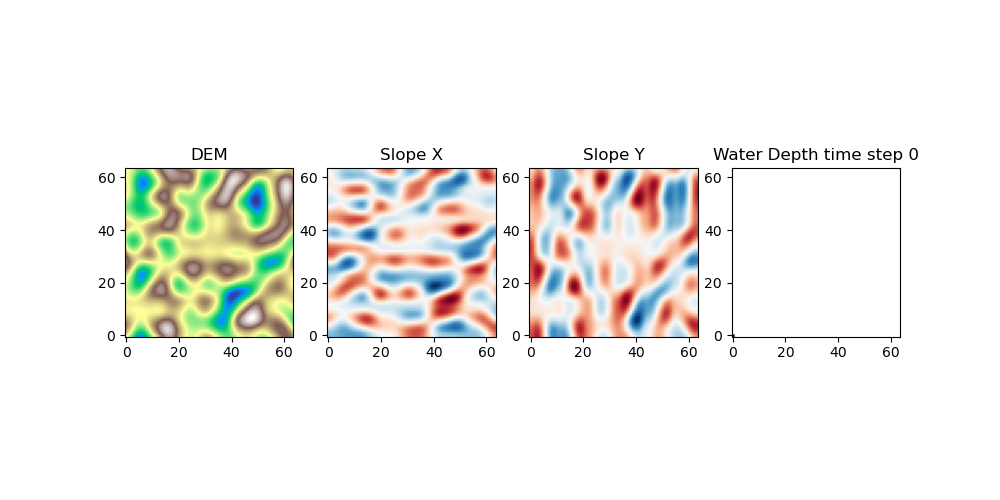

In [10]:
# From FAT application
fig, axs = plt.subplots(1, 4, figsize=(10, 5))

# specify which entry of the dataset to plot
numb = 0

axs[0].imshow(train_dataset[numb][0][0][0].cpu(), cmap='terrain', origin='lower')
axs[0].set_title('DEM')

axs[1].imshow(train_dataset[numb][0][0][1].cpu(), cmap='RdBu', origin='lower')
axs[1].set_title('Slope X')

axs[2].imshow(train_dataset[numb][0][0][2].cpu(), cmap='RdBu', origin='lower')
axs[2].set_title('Slope Y')

axs[3].imshow(train_dataset[numb][0][0][3].cpu(), cmap='binary', origin='lower')
axs[3].set_title('Water Depth time step 0')

In [11]:
# Normalize the inputs and outputs using training dataset
scaler_x, scaler_wd, scaler_q = scaler(train_dataset)

normalized_train_dataset = normalize_dataset(train_dataset, scaler_x, scaler_wd, scaler_q)
norm_test1 = normalize_dataset(test_dataset1, scaler_x, scaler_wd, scaler_q)
norm_test2 = normalize_dataset(test_dataset2, scaler_x, scaler_wd, scaler_q)
norm_test3 = normalize_dataset(test_dataset3, scaler_x, scaler_wd, scaler_q)

In [12]:
# Model: has to be the same as in other notebook
model = ConvLSTM(input_dim = normalized_train_dataset[0][0].shape[1], output_dim = normalized_train_dataset[0][1].shape[1],
                 hidden_dim = 8, kernel_size = (5, 5), num_layers = normalized_train_dataset[0][1].shape[0], batch_first=True,
                 bias=True, return_all_layers = True).to(device)

In [13]:
model

ConvLSTM(
  (conv2): Conv2d(8, 2, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (cell_list): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(12, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (1-47): 47 x ConvLSTMCell(
      (conv): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
  )
)

In [14]:
# Create the test dataloaders to "feed" data to the model
test1_loader = DataLoader(norm_test1, batch_size = 4, shuffle = False)
test2_loader = DataLoader(norm_test2, batch_size = 4, shuffle = False)
test3_loader = DataLoader(norm_test3, batch_size = 4, shuffle = False)

In [15]:
# load model no avoid training every time notebook is run
model.load_state_dict(torch.load(save_path, map_location = torch.device(device)))

<All keys matched successfully>

In [16]:
test_loss = evaluation_conv_lstm(model, test1_loader, device=device)

In [17]:
test_loss2 = evaluation_conv_lstm(model, test2_loader, device=device)

In [18]:
test_loss3 = evaluation_conv_lstm(model, test3_loader, device=device)

In [19]:
print(f'Test_loss:\n'
      f'\t First test dataset: {test_loss :.4f}\n'
      f'\t Second test dataset: {test_loss2 :.4f}\n'
      f'\t Third test dataset: {test_loss3 :.4f}')

Test_loss:
	 First test dataset: 0.0014
	 Second test dataset: 0.0030
	 Third test dataset: 0.0024


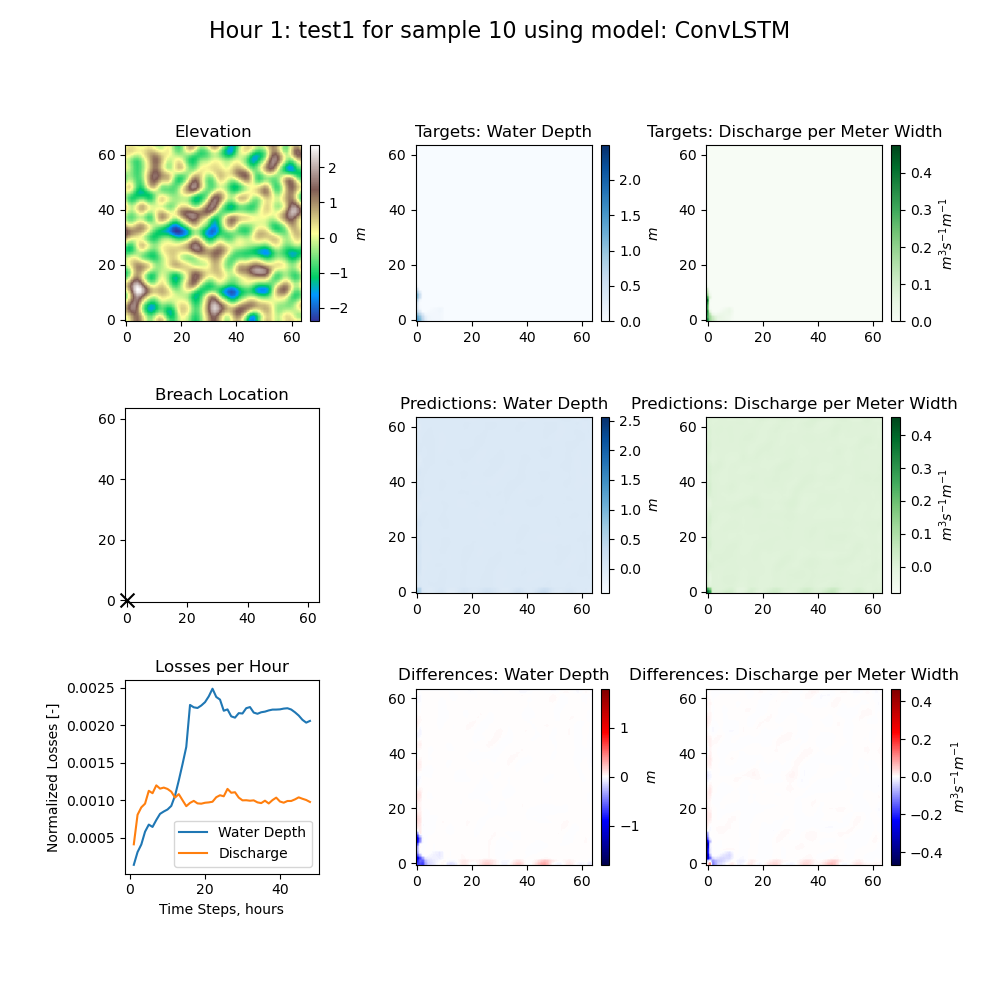

MovieWriter Pillow unavailable; using Pillow instead.


In [20]:
plot_animation(10, norm_test1, model, test1,  scaler_x, scaler_wd, scaler_q, device = device, save = True)